In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load metadata
csv_path = "videos_metadata.csv"
df = pd.read_csv(csv_path)
print(df.head())

   split                                   video_id      gesture  label  \
0  train  WIN_20180926_18_05_07_Pro_Right_Swipe_new  Right_Swipe      1   
1  train    WIN_20180926_16_56_13_Pro_Thumbs_Up_new    Thumbs_Up      4   
2  train  WIN_20180907_16_03_54_Pro_Right Swipe_new  Right_Swipe      1   
3  train  WIN_20180926_17_42_43_Pro_Right_Swipe_new  Right_Swipe      1   
4  train  WIN_20180926_16_59_03_Pro_Thumbs_Down_new  Thumbs_Down      3   

                                           file_path  num_frames  \
0  processed_dataset\train\Right_Swipe\WIN_201809...          30   
1  processed_dataset\train\Thumbs_Up\WIN_20180926...          30   
2  processed_dataset\train\Right_Swipe\WIN_201809...          30   
3  processed_dataset\train\Right_Swipe\WIN_201809...          30   
4  processed_dataset\train\Thumbs_Down\WIN_201809...          30   

   is_augmented source_video_id  
0         False             NaN  
1         False             NaN  
2         False             NaN  
3   

In [ ]:
# Data loading function

def load_npy_file(path, label):
    x = np.load(path.numpy().decode("utf-8")).astype("float32")  
    return x, np.int32(label)

def tf_load_npy(path, label):
    x, y = tf.py_function(load_npy_file, [path, label], [tf.float32, tf.int32])

    
    x.set_shape((30, 64, 64, 3))
    y.set_shape(())

    x = tf.image.resize(x, (224, 224))

    x.set_shape((30, 224, 224, 3))

    return x, y

def build_dataset(df, batch_size=8, shuffle=True):
    paths = df["file_path"].values
    labels = df["label"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(df))
    ds = ds.map(tf_load_npy, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [4]:
# Split data
train_df = df[df["split"] == "train"]
val_df   = df[df["split"] == "val"]
test_df  = df[df["split"] == "test"]

print("TRAIN:", len(train_df))
print("VAL:", len(val_df))
print("TEST:", len(test_df))

TRAIN: 560
VAL: 115
TEST: 115


In [5]:
# Sample check
sample = train_df.iloc[0]
file_path = sample["file_path"]
label = sample["label"]
print("Path:", file_path)
print("Label:", label)

Path: processed_dataset\train\Right_Swipe\WIN_20180926_18_05_07_Pro_Right_Swipe_new.npy
Label: 1


In [6]:
# Build datasets
train_ds = build_dataset(train_df)
val_ds = build_dataset(val_df, shuffle=False)
test_ds = build_dataset(test_df, shuffle=False)

In [7]:
# Check number of classes
num_classes = df["label"].nunique()
print("Number of classes:", num_classes)

# Check sample shape
sample = np.load(train_df["file_path"].iloc[0])
print("Sample shape:", sample.shape)

Number of classes: 5
Sample shape: (30, 64, 64, 3)


In [8]:
# Build model
num_classes = df["label"].nunique()

feature_extractor_url = "https://tfhub.dev/google/imagenet/inception_v1/feature_vector/5"
feature_extractor = hub.KerasLayer(
    feature_extractor_url,
    trainable=False
)

inputs = layers.Input(shape=(30, 224, 224, 3))
x = layers.TimeDistributed(layers.Lambda(lambda frame: feature_extractor(frame)))(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 30, 1024)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,685 (1.01 MB)

 Trainable params: 263,685 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#TRAIN CLASSIFIER HEAD
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.2271 - loss: 1.8442 - val_accuracy: 0.5304 - val_loss: 1.2177
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.5446 - loss: 1.1342 - val_accuracy: 0.5826 - val_loss: 1.0472
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.5956 - loss: 1.0043 - val_accuracy: 0.5913 - val_loss: 0.9056
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.6936 - loss: 0.8417 - val_accuracy: 0.6957 - val_loss: 0.8133
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7442 - loss: 0.6720 - val_accuracy: 0.7217 - val_loss: 0.7551
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.7761 - loss: 0.6199 - val_accuracy: 0.7565 - val_loss: 0.7543
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8045 - loss: 0.5388 - val_accuracy: 0.6696 - val_loss: 0.8497
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.8139 - loss: 0.5282 - val_accuracy: 0.7043 - v

Training completed. Graphs saved.


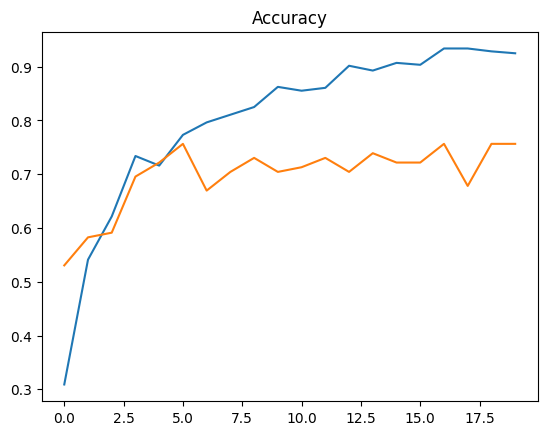

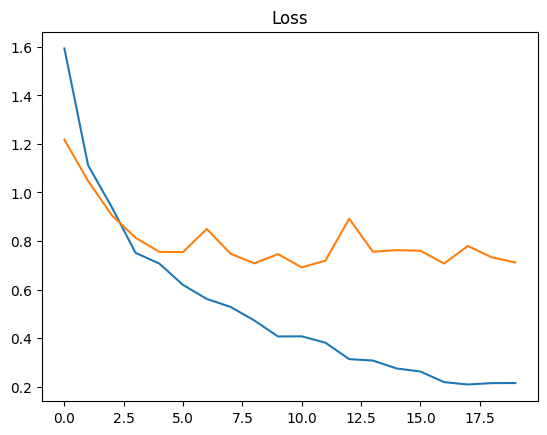

In [10]:
# 6. GENERATE GRAPHS 
def plot_graphs(hist):
    plt.figure()
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Accuracy')
    plt.savefig('accuracy.png')

    plt.figure()
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Loss')
    plt.savefig('loss.png')

plot_graphs(history)

print("Training completed. Graphs saved.")

In [11]:
# Evaluate on test data
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Evaluating on test set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.6563 - loss: 0.7819
Test Loss: 0.7931
Test Accuracy: 0.6696


In [12]:
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score, 
                             roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize

# 1. Setup Class Names and Predictions
print("Extracting class names and generating predictions...")

label_map = df[['label', 'gesture']].drop_duplicates().sort_values('label')
class_names = label_map['gesture'].tolist()
n_classes = len(class_names)
print(f"Detected {n_classes} classes: {class_names}")

y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds)
y_pred = np.argmax(y_prob, axis=1)

Extracting class names and generating predictions...
Detected 5 classes: ['Left_Swipe', 'Right_Swipe', 'Stop', 'Thumbs_Down', 'Thumbs_Up']
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step



--- Confusion Matrix ---


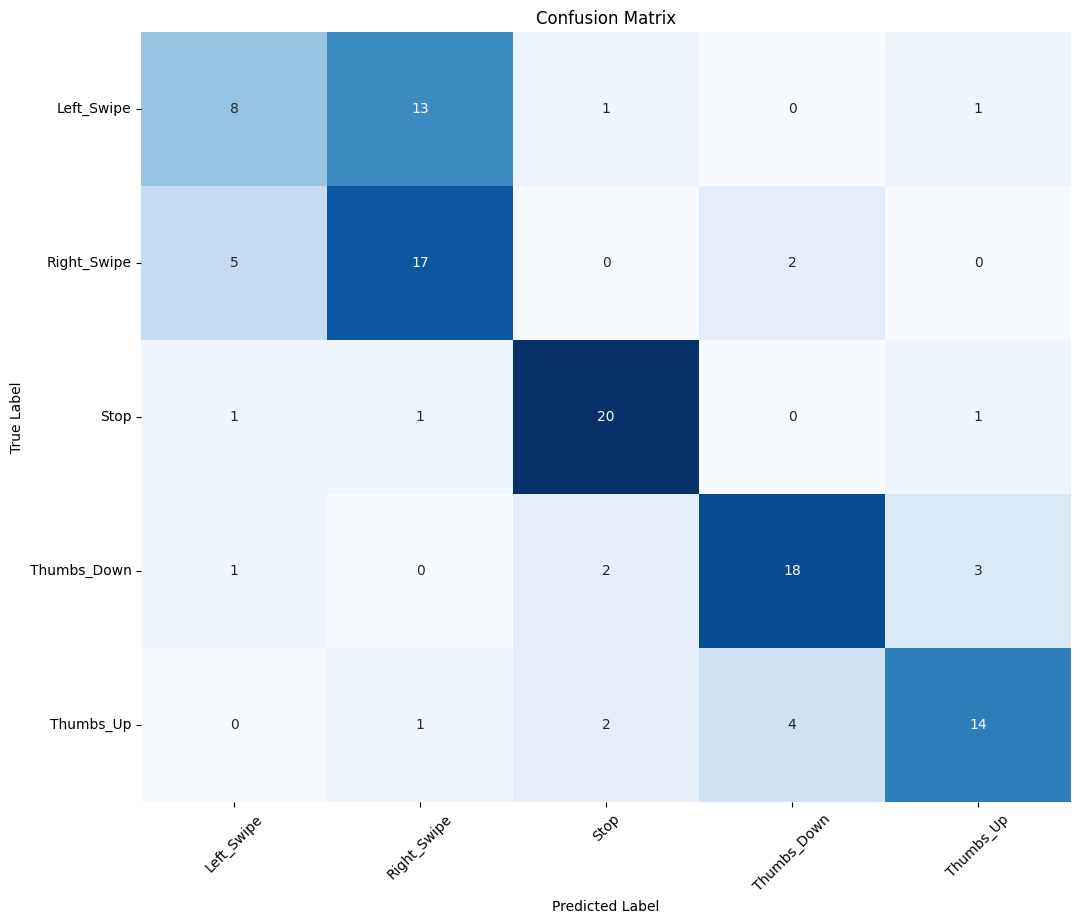

In [13]:
# 2. Confusion Matrix + Visualization
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [14]:
# 3. Precision, Recall, F1-Score
print("\n--- Classification Metrics ---")
p = precision_score(y_true, y_pred, average='weighted')
r = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Weighted Precision: {p:.4f}")
print(f"Weighted Recall:    {r:.4f}")
print(f"Weighted F1-Score:  {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


--- Classification Metrics ---
Weighted Precision: 0.6686
Weighted Recall:    0.6696
Weighted F1-Score:  0.6619

Detailed Classification Report:
              precision    recall  f1-score   support

  Left_Swipe       0.53      0.35      0.42        23
 Right_Swipe       0.53      0.71      0.61        24
        Stop       0.80      0.87      0.83        23
 Thumbs_Down       0.75      0.75      0.75        24
   Thumbs_Up       0.74      0.67      0.70        21

    accuracy                           0.67       115
   macro avg       0.67      0.67      0.66       115
weighted avg       0.67      0.67      0.66       115



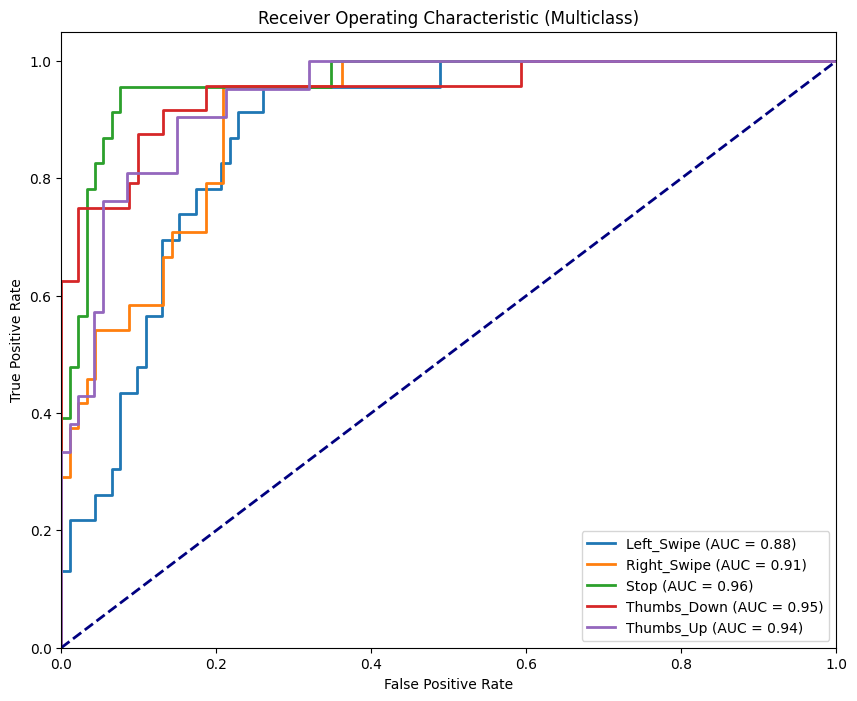

In [15]:
# 4. ROC Curve & AUC for 5 Classes

y_true_bin = label_binarize(y_true, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, 
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multiclass)')
plt.legend(loc="lower right")
plt.show()